## Importing Libraries

In [1]:
import os
import pickle
import warnings
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
import os

In [3]:
# Replace with the path to the MP3 file you want to delete
mp3_file = "output.mp3"

# Check if the file exists before attempting to delete it
if os.path.exists(mp3_file):
    os.remove(mp3_file)
    print(f"{mp3_file} has been deleted.")
else:
    print(f"{mp3_file} does not exist or cannot be deleted.")
    # Replace with the path to the MP3 file you want to delete
mp3_file = "output2.mp3"

# Check if the file exists before attempting to delete it
if os.path.exists(mp3_file):
    os.remove(mp3_file)
    print(f"{mp3_file} has been deleted.")
else:
    print(f"{mp3_file} does not exist or cannot be deleted.")
    # Replace with the path to the MP3 file you want to delete
mp3_file = "output.wav"

# Check if the file exists before attempting to delete it
if os.path.exists(mp3_file):
    os.remove(mp3_file)
    print(f"{mp3_file} has been deleted.")
else:
    print(f"{mp3_file} does not exist or cannot be deleted.")

output.mp3 does not exist or cannot be deleted.
output2.mp3 does not exist or cannot be deleted.
output.wav has been deleted.


In [4]:
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io

# Replace with your own values
CREDENTIALS_FILE = 'Curious Arch.json'
FILE_ID = 'FILEID'
OUTPUT_MP3_FILE = 'output.mp3'

# Authenticate using service account credentials
credentials = service_account.Credentials.from_service_account_file(CREDENTIALS_FILE, scopes=['https://www.googleapis.com/auth/drive.readonly'])
drive_service = build('drive', 'v3', credentials=credentials)

# Download the MP4 file
request = drive_service.files().get_media(fileId=FILE_ID)
fh = io.FileIO(OUTPUT_MP3_FILE, 'wb')
downloader = MediaIoBaseDownload(fh, request)

done = False
while not done:
    status, done = downloader.next_chunk()
    print(f"Download {int(status.progress() * 100)}%")

print("MP4 downloaded successfully")

import subprocess

input_file = OUTPUT_MP3_FILE
output_file = "output2.mp3"

# Run FFmpeg to convert the input MP4 to MP3
ffmpeg_command = f'ffmpeg -i {input_file} -vn -ar 44100 -ac 2 -ab 192k -f mp3 {output_file}'
subprocess.call(ffmpeg_command, shell=True)

print("MP3 conversion complete")


## Defining segment length frame rate and bit rate 

In [ ]:
from pydub import AudioSegment

# Replace with the path to your input MP3 file
mp3_file = "output2.mp3"

# Load the MP3 file
audio = AudioSegment.from_mp3(mp3_file)

# Specify the output WAV file
wav_file = "output.wav"

# Export the audio as WAV
audio.export(wav_file, format="wav")

print(f"Conversion from MP3 to WAV completed: {wav_file}")

# Replace with the path to the MP3 file you want to delete
mp3_file = "output2.mp3"

# Check if the file exists before attempting to delete it
if os.path.exists(mp3_file):
    os.remove(mp3_file)
    print(f"{mp3_file} has been deleted.")
else:
    print(f"{mp3_file} does not exist or cannot be deleted.")

mp3_file = "output.mp3"

# Check if the file exists before attempting to delete it
if os.path.exists(mp3_file):
    os.remove(mp3_file)
    print(f"{mp3_file} has been deleted.")
else:
    print(f"{mp3_file} does not exist or cannot be deleted.")

Conversion from MP3 to WAV completed: output.wav
output2.mp3 has been deleted.
output.mp3 has been deleted.


In [ ]:
segLen,frameRate,numMix = 3,50,128

## Function for Voice Activity Detection

In [ ]:
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(y=wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [ ]:
wavFile="output.wav"

In [ ]:
wavData,_ = librosa.load(wavFile,sr=16000)
%time vad=VoiceActivityDetection(wavData,frameRate)

CPU times: user 900 ms, sys: 65 ms, total: 965 ms
Wall time: 965 ms


In [ ]:
mfcc = librosa.feature.mfcc(y=wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
vad = np.reshape(vad,(len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad,:];

## N_Component

In [ ]:
# n_components = np.arange(1, 25)
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
#           for n in n_components]

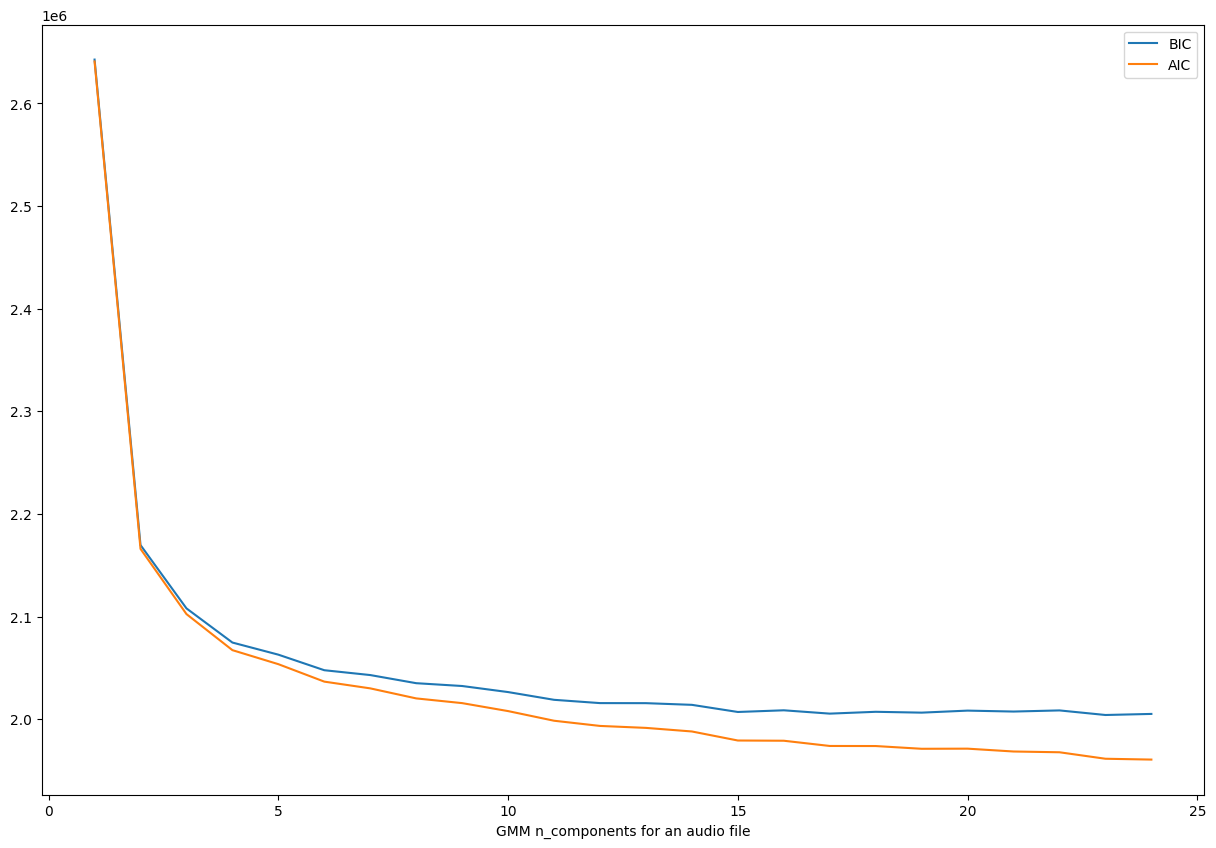

In [ ]:
# plt.figure(figsize=(15, 10))
# plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('GMM n_components for an audio file');

## GMM Training

In [ ]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData,_ = librosa.load(wavFile,sr=16000)
    mfcc = librosa.feature.mfcc(y=wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
    vad = np.reshape(vad,(len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];
    print("Training GMM..")
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")

    return np.asarray(segLikes)

In [ ]:
clusterset = trainGMM(
    wavFile, frameRate, segLen, vad, numMix
)

Training GMM..
Training Done


## Clustering Analysis

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterset)  
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
X_normalized = normalize(X_scaled)

In [ ]:

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
clust=cluster.fit_predict(X_normalized)

/home/ubuntu/vispr/env/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


## Convert Segment to Frame

In [ ]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

In [ ]:
frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])


## Adding Speaker Labels

In [ ]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
            
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal
    

In [ ]:
pass1hyp = -1*np.ones(len(vad))
pass1hyp[vad] = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, wavFile)


In [ ]:
spkdf["TimeSeconds"]=spkdf.EndTime-spkdf.StartTime

In [ ]:
spkdf

,Audio,SpeakerLabel,StartTime,EndTime,TimeSeconds
0,output.wav,Speaker 1,1.50,8.26,6.76
1,output.wav,Speaker 0,8.26,156.88,148.62
2,output.wav,Speaker 1,156.88,165.66,8.78
3,output.wav,Speaker 0,165.66,216.84,51.18
4,output.wav,Speaker 1,216.84,225.30,8.46
5,output.wav,Speaker 0,225.30,232.86,7.56
6,output.wav,Speaker 1,232.86,241.24,8.38
7,output.wav,Speaker 0,241.24,310.68,69.44
8,output.wav,Speaker 1,310.68,315.20,4.52
9,output.wav,Speaker 0,315.20,393.58,78.38


In [ ]:
os.listdir()

['config.cfg',
 'Speaker Diarization.ipynb',
 'cd',
 '.git',
 'Speaker Diarisation.wav',
 'new.ipynb',
 'Speaker Diarization Demo.wav',
 '__pycache__',
 'requirements.txt',
 'python',
 'README.md',
 'pytorch_model.bin',
 'my_namespace.MyTask.v1_config.cfg',
 'video',
 'notebook.ipynb',
 'Curious Arch.json',
 '.DS_Store',
 'config.yaml',
 'env',
 'convert.py',
 'ter.mp4',
 '.gitignore',
 'Resemblyzer',
 'speakers',
 'mashup.mp3',
 'explore.ipynb',
 'Speaker Diarization Demo.mp3',
 'functions.py',
 'output.wav']

In [ ]:
from moviepy.editor import AudioFileClip
import os

def divide_into_parts(uniq_dir, times, input_audio_file):
    if uniq_dir not in os.listdir():
        os.mkdir(uniq_dir)
    try:
        audio = AudioFileClip(input_audio_file)
        timestamp = 0
        parts = []

        for timelength in times:
            parts.append(audio.subclip(timestamp, timestamp + timelength))
            timestamp += timelength

        for i, fragment in enumerate(parts):
            fragment.write_audiofile(os.path.join(uniq_dir, f'part_{i}.mp3'))
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
input_audio_file = 'Speaker Diarisation.wav'
uniq_dir = "parts"
 # Replace with the actual time durations you want
divide_into_parts(uniq_dir, spkdf["TimeSeconds"], input_audio_file)

MoviePy - Writing audio in parts/part_0.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_1.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_2.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_3.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_4.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_5.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_6.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_7.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_8.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_9.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_10.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_11.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_12.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_13.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_14.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_15.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_16.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_17.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_18.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_19.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_20.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_21.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_22.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_23.mp3


MoviePy - Done.
MoviePy - Writing audio in parts/part_24.mp3


MoviePy - Done.


In [ ]:
import re
import whisper
from requests import request

def transcribe(file, key,labels, model="base", count=0):
    model = whisper.load_model(model)
    transcript = model.transcribe(os.path.join(key, file))
    return labels[count]+ ":" +transcript['text']
    
    
def transcribe_all(uniq_dir,labels, model = 'base'):
    #creating expresion for better speed
    p = re.compile(r'\d+')
    whole_transcript = []
    parts = os.listdir(os.path.join(uniq_dir))
    #sorting parts list
    parts = sorted(parts, key=lambda s: int(p.search(s).group()))
    count = 0
    for file in parts:
        text = transcribe(file, uniq_dir,labels, model=model, count=count)
        whole_transcript.append(text)
        os.remove(os.path.join(uniq_dir, file))
        count += 1
    os.rmdir(os.path.join(uniq_dir))
    whole_transcript = " ".join(whole_transcript)
    return whole_transcript

final_transcript = transcribe_all(uniq_dir="parts", labels=spkdf["SpeakerLabel"])

In [ ]:
final_transcript

"Speaker 1: Okay, I was wondering if you could tell me a little bit about the program. What exactly goes on? Speaker 0: Okay, well basically it's an intensive program designed to last four weeks. Each session is four weeks long, although we do have two sessions in 1996 that will be two weeks long. But our general four week session involves seven hours of contact each day of Spanish. It involves starting at nine o'clock in the morning with three hours of grammar instruction. And then it's followed immediately by an hour of group conversation with the same instructor, same class. But we have extensive gardens here at the Institute and so students will usually go out to a garden setting because it's a little more comfortable. And then after a break for lunch, students return and we have a complete flip of instruction in that instead of textbook and clinical type instruction, we have hands on. And we offer workshops in Mehe Backstrap leaving regional cooking of Wahaka at Don Pasnell potter

In [ ]:
def partition_text(transcript, stop_word_num=180):
    # divide the transcript into words
    words = transcript.split()

    # Create an empty list to store partitioned text, string to store the words before the stop word and a counter
    partitioned_text = []
    before_stop_word = ""
    counter = 0
    # Iterate over the words in the string
    for word in words:
        # Check if you've reached the word you want to stop at
        if counter == stop_word_num:
            if word[-1] != '.':
                # After the values is reached append until you reach an end of sentence ('.')
                before_stop_word += word + " "
            else:
                before_stop_word += word + " "
                # and finally, add the whole sentence as an element of the partitioned text list
                partitioned_text.append(before_stop_word)
                # Reset before_stop_word to an empty string and counter set to 0
                before_stop_word = ""
                counter = 0
        else:
            # Append the current word to the new string
            before_stop_word += word + " "
            counter = counter + 1
    else:
        if before_stop_word != '':
            # catch the last remaining part of text into another element of the list
            partitioned_text.append(before_stop_word)

    # print(partitioned_text)
    return partitioned_text
partition_text = partition_text(final_transcript)


In [ ]:
partition_text

["Speaker 1: Okay, I was wondering if you could tell me a little bit about the program. What exactly goes on? Speaker 0: Okay, well basically it's an intensive program designed to last four weeks. Each session is four weeks long, although we do have two sessions in 1996 that will be two weeks long. But our general four week session involves seven hours of contact each day of Spanish. It involves starting at nine o'clock in the morning with three hours of grammar instruction. And then it's followed immediately by an hour of group conversation with the same instructor, same class. But we have extensive gardens here at the Institute and so students will usually go out to a garden setting because it's a little more comfortable. And then after a break for lunch, students return and we have a complete flip of instruction in that instead of textbook and clinical type instruction, we have hands on. And we offer workshops in Mehe Backstrap leaving regional cooking of Wahaka at Don Pasnell potte

In [ ]:
final_input = ""
for sentence in partition_text:
    final_input = final_input + sentence

In [ ]:
import openai
import os

#This code is designed to generate summaries for the input text partitions using the OpenAI GPT-3 model.
# The function divides the input text into partitions and generates summaries for each partition, combining them into a final summary. 
def request_summary(input_text, temperature=0.1, max_tokens=768):
    openai.api_key = "OPENAIKEY"
    summary = ""
    for text_partition in input_text:
        if text_partition != '':
            response = openai.Completion.create(
                max_tokens=max_tokens,
                model="text-curie-001",
                prompt=summarize_prompt(text_partition),
                temperature=temperature,
            )
            summary = summary + str(response.choices[0].text)
    return summary


def request_actionitems(input_text, temperature=0.1, max_tokens=768):
    openai.api_key = "OPENAIKEY"
    summary = ""
    for text_partition in input_text:
        if text_partition != '':
            response = openai.Completion.create(
                max_tokens=max_tokens,
                model="text-curie-001",
                prompt=actionitems_prompt(text_partition),
                temperature=temperature,
            )
            summary = summary + str(response.choices[0].text)
    return summary


# GPT3 methods
def actionitems_prompt(prompt):
    return """Could you give the action items from this meeting transcript if any ?
    \"{}\"""".format(prompt)

def action_item_prompt(prompt):
    return """give me precisely the action points in this meeting? in as few lines as possible. 
    \"{}\"""".format(prompt)


# GPT3 methods
def summarize_prompt(prompt):
    return """Could you precisely get the summary of this meeting? in less than 10 points. 
    \"{}\"""".format(prompt)


def reformat_prompt(prompt):
    return """Could you reformat this text? 
    \"{}\"""".format(prompt)
# Now we need to make another function Request_acitems:  and another function insights_promt: for generating insights ...

In [ ]:
summary = request_summary(partition_text)


In [ ]:
actions_items = request_actionitems(partition_text)
actions_items

'\n\n-Grammar instruction \n-Group conversation \n-Hands on instruction \n-Workshops\n\n-Create a Spanish language learning environment that is hands-on and engaging \n-Offer weekly lectures and cultural presentations \n-Provide optional tours to cultural attractions around Wahaka\n\n-Give a placement test \n-Talk to the student after the placement test \n-Grade the placement test\n\n-Assignments for each group \n-Instructions for students who do not arrive at the beginning of the session \n-Schedule for the program\n\n-Speaker 1: "And for another thing. Uh-huh. And are you commenting on this?"\n-Speaker 0: "We offer several options. The vast majority of residents take host family homes as the way to go when they\'re here in Wahaka. They pay a base price of $11 a day, and that includes a private room and full breakfast. And it may or may not include a private bath. It really depends on each family."\n\n-To communicate with the students, the staff should be available to answer any quest

In [ ]:
len(summary), len(actions_items), len(final_input)

(2304, 2985, 8923)

In [ ]:
summary

"\n\nThe speaker is discussing the program at the Institute of Spanish Language and Culture. The program is designed to last four weeks and involves seven hours of contact each day. The program begins with three hours of grammar instruction and then students have an hour of group conversation with the same instructor. After lunch, the program switches to hands on instruction with workshops in Mehe Backstrap and folkloric dance.\n\nThe summary of this meeting is that the students are learning a craft and Spanish language acquisition is facilitated with a hands-on project. The last hour is an intercombo hour where a student from the community in Wahaka comes to the Institute to work with one of the students.\n\nThe speaker are discussing the placement test that new students will take upon arrival. The test is designed to place students into one of seven levels of Spanish proficiency. The first part of the test is written, and the second part is a conversation with an instructor.\n\nThe m

In [ ]:
final_input

"Speaker 1: Okay, I was wondering if you could tell me a little bit about the program. What exactly goes on? Speaker 0: Okay, well basically it's an intensive program designed to last four weeks. Each session is four weeks long, although we do have two sessions in 1996 that will be two weeks long. But our general four week session involves seven hours of contact each day of Spanish. It involves starting at nine o'clock in the morning with three hours of grammar instruction. And then it's followed immediately by an hour of group conversation with the same instructor, same class. But we have extensive gardens here at the Institute and so students will usually go out to a garden setting because it's a little more comfortable. And then after a break for lunch, students return and we have a complete flip of instruction in that instead of textbook and clinical type instruction, we have hands on. And we offer workshops in Mehe Backstrap leaving regional cooking of Wahaka at Don Pasnell potter

In [ ]:
def generate_html_summary_and_action_items(summary, action_items):
    action_items_list = action_items.split('\n\n')
    action_items_html = "<ul>\n"
    
    for item in action_items_list:
        if item.strip():  # Exclude empty lines
            action_items_html += f"<li>{item.strip()}</li>\n"
    
    action_items_html += "</ul>"

    html = f"""
    <html>
    <head>
        <title>Meeting Summary and Action Items</title>
    </head>
    <body>
        <h2>Meeting Summary</h2>
        <p>{summary}</p>
        
        <h2>Action Items</h2>
        {action_items_html}
    </body>
    </html>
    """

    return html

# Test the function
html_content = generate_html_summary_and_action_items(summary, actions_items)


In [ ]:
# This code sample uses the 'requests' library:
# http://docs.python-requests.org
import requests
from requests.auth import HTTPBasicAuth
import json


def create_page(html, title):
    url = "https://nihal7676.atlassian.net/wiki/api/v2/pages" 
    auth_token = "AUTHKEY"
    auth = HTTPBasicAuth('puramnihal@gmail.com', auth_token)

    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json"
    }

    page_html = html

    payload = json.dumps({
        "spaceId": "1769475",
        "status": "current",
        "title": title,
        "parentId": "1769705",
        "body": {
            "representation": "storage",
            "value": page_html,
        }
    })

    response = requests.request(
        "POST",
        url,
        data=payload,
        headers=headers,
        auth=auth
    )       

    print(json.dumps(json.loads(response.text),
        sort_keys=True, indent=4, separators=(",", ": ")))


In [ ]:
create_page(html_content, "Meeting Summary")

{
    "_links": {
        "editui": "/pages/resumedraft.action?draftId=2424865",
        "tinyui": "/x/IQAl",
        "webui": "/spaces/aws/pages/2424865/Meeting+Summary"
    },
    "authorId": "712020:1db39195-fe1d-4c90-9a5c-a94187512f5e",
    "body": {
        "storage": {
            "representation": "storage",
            "value": "\n    \n        <h2>Meeting Summary</h2>\n        <p>\n\nThe speaker is discussing the program at the Institute of Spanish Language and Culture. The program is designed to last four weeks and involves seven hours of contact each day. The program begins with three hours of grammar instruction and then students have an hour of group conversation with the same instructor. After lunch, the program switches to hands on instruction with workshops in Mehe Backstrap and folkloric dance.\n\nThe summary of this meeting is that the students are learning a craft and Spanish language acquisition is facilitated with a hands-on project. The last hour is an intercombo 